### The following code reproduces the important results of the paper.

The next cell imports utilities and defines some basic functions.
See the following figure (taken from the paper), for a basic scheme of the task and the model.

<img src="scheme.pdf" width="800" height="600">


coherence_from_mu converts the mean $\mu$ of the Gaussian distribution, used to define the external signal, to a coherence value, which is commonly adopted in decision-making experiments.

mu_from_coherence does the inverse operation, converting a specific coherence value to the mean of the Gaussian distribution.



In [94]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import os
import sys

sys.path.insert(1, os.getcwd())
import multi_scale_agent as td_jit

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)


## The following factor is used for the conversion from mu to coherence and viceversa. It has been selected to obtain good 
## agreement with experimental results (see the paper for more details).
coherence_to_mu_factor = 0.216


def coherence_from_mu(mu_norm):
    if type(mu_norm) == list:
        mu_norm = np.array(mu_norm)

    x0 = coherence_to_mu_factor
    return (-(mu_norm ** 2) + np.sqrt(mu_norm ** 4 + 400 * mu_norm ** 2 * x0 ** 2)) / (
        2 * x0 ** 2
    )


def mu_from_coherence(c):
    if type(c) == list:
        c = np.array(c)
    return coherence_to_mu_factor * c / np.sqrt(100.0 - c)

In the next cell,
the first functions are useful for basic computation, while the functions
 
compute_shadlen takes as input the parameters defining an agent and computes the Delta_Sigma for different coherence values   aligned from the start of the episode (align2start) and aligned from the decision time (aligned2decision)
 
plot_shadlen takes the output of compute_shadlen to construct a plot similar to Fig. 4 of the paper


In [ ]:
# Utilities

def is_float(potential_float):
    try:
        float(potential_float)
        return True
    except Exception:
        return False


def find_closest(v, x, scale="lin"):
    if is_float(x):
        if scale.lower() == "lin":
            idx = np.abs(v - x).argmin()
        elif scale.lower() == "log":
            idx = np.abs(np.log(v) - np.log(x)).argmin()
        return v[idx], idx
    else:
        x_ = np.array(x)

        values = np.zeros_like(x_)
        idxs = np.zeros((x_.size,), int)
        for k, y in enumerate(x_):
            if scale.lower() == "lin":
                idx = np.abs(v - y).argmin()
            elif scale.lower() == "log":
                idx = np.abs(np.log(v) - np.log(y)).argmin()
            idxs[k] = idx
            values[k] = v[idx]
        return values, idxs


def perc(n):
    def percentile_(x):
        return np.percentile(x, n)

    percentile_.__name__ = f"{n}%"
    return percentile_


def move_col_after(df_in, col, after):
    df = df_in.copy()
    column = df.pop(col)
    df.insert(
        df.columns.get_loc(after) + 1, column.name, column, allow_duplicates=False,
    )
    return df


def move_col_before(df_in, col, before):
    df = df_in.copy()
    column = df.pop(col)
    df.insert(df.columns.get_loc(before), column.name, column, allow_duplicates=False)
    return df


def compute_shadlen(
    episodes,
    signals,
    ws,
    dt=0.01,
    n_t_max=None,
    p3_tot_abs=False,
    start_to_percentile=50.0,
    end_to_percentile=None,
    start_to_n_samples=None,
    end_to_n_samples=None,
):
    def percentile(n):
        def percentile_(x):
            return np.percentile(x, n)

        percentile_.__name__ = "percentile_%s" % n
        return percentile_

    if "t_max" in episodes:
        y = signals.merge(
            episodes[(episodes["rt"] < episodes["t_max"]) | (episodes["a"] != 2)],
            on="episode",
            how="right",
        )
    else:
        if n_t_max is None:
            n_t_max = signals["t"].max()
        y = signals.merge(
            episodes[(episodes["rt"] < n_t_max) | (episodes["a"] != 2)],
            on="episode",
            how="right",
        )
    y["success"] = (y["r"] > 0.0).astype(int)
    episodes["success"] = (episodes["r"] > 0.0).astype(int)

    n_taus = (ws.shape[1] - 1) // 2

    # Compute DeltaSigmas
    ints = y[["int_" + str(k) for k in range(n_taus)]].values
    y["DeltaSigmaS"] = ws[0, :n_taus] @ ints.T
    if p3_tot_abs:
        y["DeltaSigmaS"] -= np.abs(ws[2, :n_taus] @ ints.T)
    else:
        y["DeltaSigmaS"] -= ws[2, :n_taus] @ np.abs(ints).T

    ints = y[["int_t_" + str(k) for k in range(n_taus)]].values
    y["DeltaSigmaT"] = (
        ws[0, n_taus : 2 * n_taus] - ws[2, n_taus : 2 * n_taus]
    ) @ ints.T

    y["DeltaSigma"] = y["DeltaSigmaS"] + y["DeltaSigmaT"] + ws[0, -1] - ws[2, -1]
    del ints

    for k in range(n_taus):
        y["abs_int_" + str(k)] = y["int_" + str(k)].abs()

    y = move_col_before(y, "DeltaSigma", "int_0")
    y = move_col_before(y, "DeltaSigmaS", "int_0")
    y = move_col_before(y, "DeltaSigmaT", "int_0")

    def f(c):
        if c == "int_0":
            return ("mean", "count")
        if c.startswith("DeltaSigma"):
            return ("mean", "std")
        else:
            return "mean"

    if end_to_percentile is not None and end_to_percentile < 100.0:
        align2decision = y.merge(
            episodes.groupby(["mu", "a", "success"])
            .agg({"rt": percentile(end_to_percentile)})
            .reset_index()
            .rename(columns={"rt": "max_rt"}),
            on=["mu", "a", "success"],
        )
        align2decision = align2decision[
            (align2decision["t_back"] < align2decision["max_rt"])
            & (align2decision["t"] * dt * 1000.0 >= 0)
        ]
        del align2decision["max_rt"]
    else:
        align2decision = y.copy()

    align2decision = (
        align2decision.groupby(["t_back", "mu", "success", "a"])
        .agg(
            {
                c: f(c)
                for c in align2decision.columns
                if c[:3] == "int"
                or c == "r"
                or c[: len("DeltaSigma")] == "DeltaSigma"
                or c[: len("abs_int_")] == "abs_int_"
            }
        )
        .reset_index()
        .rename(columns={"t_back": "t"})
        .sort_values(["mu", "success", "t"], ascending=[False, False, True])
        .reset_index(drop=True)
    )

    # Roitman&Shadlen 2002
    # https://www.jneurosci.org/content/jneuro/22/21/9475.full.pdf
    # "The response averages shown in the left half of Figure 7A are drawn to
    # the median reaction time and do not include any activity in the 100 msec preceding saccade initiation"
    if start_to_percentile is not None and start_to_percentile < 100.0:
        align2start = y.merge(
            episodes.groupby(["mu", "a", "success"])
            .agg({"rt": percentile(start_to_percentile)})
            .reset_index()
            .rename(columns={"rt": "max_rt"}),
            on=["mu", "a", "success"],
        )
        align2start = align2start[
            (align2start["t"] < align2start["max_rt"])
            & (align2start["t_back"] * dt * 1000.0 >= 100.0)
        ]
        del align2start["max_rt"]
    else:
        align2start = y.copy()
        align2start = align2start[align2start["t_back"] * dt * 1000.0 >= 100.0]

    align2start = (
        align2start.groupby(["t", "mu", "success", "a"])
        .agg(
            {
                c: f(c)
                for c in align2start.columns
                if c[:3] == "int"
                or c == "r"
                or c[: len("DeltaSigma")] == "DeltaSigma"
                or c[: len("abs_int_")] == "abs_int_"
            }
        )
        .reset_index()
        .sort_values(["mu", "success", "t"], ascending=[False, False, True])
        .reset_index(drop=True)
    )

    del episodes["success"]

    def f(c):
        if c[1] == "mean" or len(c[1]) == 0:
            s = c[0]
        elif c[1] == "std":
            s = c[0] + "_std"
        else:
            s = c[1]
        return s

    align2decision.columns = [
        f(c)
        for c in zip(
            align2decision.columns.get_level_values(0),
            align2decision.columns.get_level_values(1),
        )
    ]
    align2decision = align2decision[
        [c for c in align2decision.columns if c[:3] != "int"]
        + [c for c in align2decision.columns if c[:3] == "int"]
    ]
    if end_to_n_samples is not None and end_to_n_samples > 0:
        align2decision = align2decision[align2decision["count"] >= end_to_n_samples]

    align2start.columns = [
        f(c)
        for c in zip(
            align2start.columns.get_level_values(0),
            align2start.columns.get_level_values(1),
        )
    ]
    align2start = align2start[
        [c for c in align2start.columns if c[:3] != "int"]
        + [c for c in align2start.columns if c[:3] == "int"]
    ]
    if start_to_n_samples is not None:
        align2start = align2start[align2start["count"] >= start_to_n_samples]
    del f

    return align2start, align2decision


def plot_shadlen(
    align2start,
    align2decision,
    ws,
    dt=0.01,
    coherence_f=None,
    plot_a2=False,
    p3_tot_abs=False,
    plot_errors=False,
    t_max_start=0.8,
    t_max_decision=0.6,
):

    fig, axs = plt.subplots(1, 2, figsize=(8, 8), sharey=True)
    fig.subplots_adjust(wspace=0.075)

    y = align2start.copy()
    mus = sorted(y.loc[y["mu"] >= -0, "mu"].unique())

    if len(mus) == 3:
        clrs = {mus[0]: "green", mus[1]: "red", mus[2]: "darkorange"}
        lgnds = {
            mus[0]: r"$\mu$ low",
            mus[1]: "$\mu$ medium",
            mus[2]: "$\mu$ high",
        }
    else:
        clrs = ["blue", "green", "crimson", "darkcyan", "purple", "darkorange"]
        clrs = {mu: clr for mu, clr in zip(mus, clrs)}
        #         clrs = {mus[0]:'blue', mus[1]:'green', mus[2]:'crimson', mus[3]:'darkcyan', mus[4]:'purple', mus[5]:'darkorange'}

        if coherence_f is None:
            lgnds = {mus[k]: f"$\mu$ = {mu:1.2f}" for k, mu in enumerate(mus)}
        else:
            lgnds = {mus[k]: f"{coherence_f(mu):1.1f}%" for k, mu in enumerate(mus)}

    del mus

    n_taus = (ws.shape[1] - 1) // 2

    for (n_case, case), correct in itertools.product(
        enumerate(["start", "decision"]), ["correct", "wrong"]
    ):

        if not plot_errors and correct == "wrong":
            continue

        if case == "start":
            y = align2start.copy()
        else:
            y = align2decision.copy()
        ax = axs[n_case]

        cols = [f"int_{k}" for k in range(n_taus)]
        z = ws[:2, :n_taus].dot(y[cols].T.values)
        if p3_tot_abs:
            print("p3_tot_abs = True")
            z[:, :] -= np.abs(ws[2, :n_taus].dot(y[cols].T.values))
        else:
            z[:, :] -= ws[2, :n_taus].dot(np.abs(y[cols].T.values))

        cols = [f"int_t_{k}" for k in range(n_taus)]
        z[:, :] += ws[:2, n_taus : 2 * n_taus].dot(y[cols].T.values)
        z[:, :] -= ws[2, n_taus : 2 * n_taus].dot(y[cols].T.values)

        z[:, :] += ws[:2, -1][:, None]
        z[:, :] -= ws[2, -1]

        y["w1"] = z[0, :].T
        y["w2"] = z[1, :].T
        del z, cols

        for mu in y.loc[y["mu"] >= -0, "mu"].unique():
            if case == "start":
                t_max = t_max_start / dt
            else:
                t_max = t_max_decision / dt

            if correct == "correct":
                x = y[(y["mu"] == mu) & (y["a"] == 0) & (y["t"] < t_max)]
            else:
                x = y[(y["mu"] == mu) & (y["a"] == 1) & (y["t"] < t_max)]

            ts = x["t"] * dt * 1000.0
            if case == "decision":
                ts = -ts

            if correct == "correct":
                line_style = "-"
                lbl = lgnds[mu]
            else:
                line_style = "--"
                lbl = "_nolabel_"

            if not plot_a2:
                ax.plot(
                    ts,
                    x["DeltaSigma"],
                    color=clrs[mu],
                    linestyle=line_style,
                    linewidth=3,
                    label=lbl,
                )
            else:
                ax.plot(
                    ts, x["w2"], color=clrs[mu], linestyle="--", linewidth=3, label=lbl,
                )

            del line_style, lbl

        ax.tick_params(axis="x", labelsize=20)

        style = dict(
            size=20,
            color="black",
            horizontalalignment="center",
            verticalalignment="center",
        )

        if case == "start":
            if not plot_a2:
                if not plot_errors:
                    leg = ax.legend(fontsize=16, loc="upper left")
                else:
                    leg = ax.legend(fontsize=16, loc="lower left")

                leg.set_title("Motion strength")
                leg.get_title().set_fontsize(24)
                del leg

            ax.spines["right"].set_color("none")
            ax.set_ylabel(r"$\Sigma$ (a.u.)", fontsize=32)
            ax.tick_params(axis="y", labelsize=24)
        else:
            ax.set_xlim((-600, 0))
            ax.yaxis.tick_right()
            ax.spines["left"].set_color("none")
            ax.tick_params(axis="y", which="both", length=0)

    fig.text(0.5, 0.04, "Time (ms)", ha="center", fontsize=32)

    M = 0.0
    lines = axs[0].lines
    for line in lines:
        M = max(M, line.get_xdata().max())

    lines = axs[1].lines
    for line in lines:
        M = max(M, -line.get_xdata().min())
    del lines, line

    M = np.ceil(M / 200.0) * 200.0
    axs[0].set_xlim([0.0, M + 100.0])
    axs[1].set_xlim([-M - 100.0, 0.0])
    del M

    plt.show()

    return fig, axs


def compute_shadlen_dist(
    episodes, signals, ws, train_agent_data, max_delta_t=60, end_to_n_samples=100,
):
    def percentile(n):
        def percentile_(x):
            return np.percentile(x, n)

        percentile_.__name__ = "percentile_%s" % n
        return percentile_

    dt = train_agent_data["dt"]
    taus = train_agent_data["taus"]
    t_max = train_agent_data["p_t_max_params"][1]
    sig = train_agent_data["sig"]
    sig_i = train_agent_data["sig_i"]
    gamma = train_agent_data["gamma"]
    use_t_integrators = train_agent_data["use_t_integrators"]
    p3_tot_abs = train_agent_data["p3_tot_abs"]
    b_exp_i_taus = train_agent_data["b_exp_i_taus"]

    _, align2decision = compute_shadlen(
        episodes,
        signals,
        ws,
        dt=dt,
        n_t_max=None,
        p3_tot_abs=p3_tot_abs,
        start_to_percentile=50.0,
        end_to_n_samples=end_to_n_samples,
    )

    n_episodes_per_mu = int(episodes.shape[0] / episodes["mu"].unique().size)

    x = align2decision.copy()

    x = x[(x["success"] == 1) & (x["a"] == 0)]
    x = x[[c for c in x.columns if not "int_" in c]]
    del x["success"], x["a"], x["r"], x["DeltaSigmaS"]
    del x["DeltaSigmaS_std"], x["DeltaSigmaT"], x["DeltaSigmaT_std"]

    del x["count"]

    if x.shape[0] > 0:
        delta_t = x["t"].max() + 1
        if delta_t > max_delta_t:
            x = x[x["t"] < max_delta_t]
            delta_t = max_delta_t

    if x.shape[0] > 0:
        x["DeltaSigma_norm"] = (x["DeltaSigma"] - x["DeltaSigma"].min()) / (
            x["DeltaSigma"].max() - x["DeltaSigma"].min()
        )

        def f(g):
            d = {}
            d["DeltaSigma_diff"] = (
                g["DeltaSigma_norm"].max() - g["DeltaSigma_norm"].min()
            )
            d["count"] = g.shape[0]
            return pd.Series(d, dtype=object)

        x = x.groupby("t").apply(f).reset_index()
        del f
        x = x[x["count"] > 1]

    if x.shape[0] > 0:
        delta_t = x["t"].max() + 1
        delta_sigma_diff_max = x["DeltaSigma_diff"].max()
        delta_sigma_diff_mean = x["DeltaSigma_diff"].mean()
    else:
        delta_t = 0
        delta_sigma_diff_max = np.inf
        delta_sigma_diff_mean = np.inf

    return delta_sigma_diff_mean, delta_sigma_diff_max, delta_t

In [3]:
%%time
# Train "standard" agent
sig = 1.8
sig_mu = 0.25
sig_i = 0.02
gamma_ = np.exp(np.log(0.5) / 10 ** 6)
use_t_integrators = True
p3_tot_abs = False

alpha0 = 10 ** -3
iter_gamma = 0.75
iter_scale = 10 ** 4

# Standard values for the timescales (taus)
n_taus = 10
tau_min = 0.1
tau_max = 10.0
b_exp_i_taus = False
tau_distr = "exp"

t_max = 2.0

p_mu_params = ["Gaussian", 0.0, sig_mu]

n_training_steps = 10 ** 5
n_test_steps = 1 * 10 ** 5

if p_mu_params[0] != "Gaussian":
    print(f"WARNING! Mu distribution ({p_mu_params[0]}) is not Gaussian")

if alpha0 != 0.001:
    print(f"WARNING! alpha0 ({alpha0}) != 0.001")

if t_max != 2:
    print(f"WARNING! t_max ({t_max}) != 2.")

if tau_distr.lower() != "exp":
    print(f'WARNING! Tau distribution is not exponential ("{tau_distr}")')

if n_taus != 10 or tau_min != 0.1 or tau_max != 10.0:
    print(
        f"WARNING! n_taus = {n_taus}, tau_min = {tau_min:1.3f}, tau_max = {tau_max:1.3f}"
    )

if sig != 1.8:
    print(f"WARNING: sig ({sig:1.3f}) != 1.8!")

if sig_mu != 0.25:
    print(f"WARNING: sig_mu ({sig_mu:1.3f}) != 0.25!")

if sig_i != 0.02:
    print(f"WARNING: sig_i ({sig_i:1.3f}) != 0.02!")

if not use_t_integrators:
    print("WARNING: not using time integrators!")

if p3_tot_abs:
    print("WARNING: using |Sum w * x|!")

if b_exp_i_taus:
    print("WARNING: b_exp_i_taus = True!")


params = (
    sig,
    p_mu_params,
    ["deterministic", t_max],
    sig_i,
    n_training_steps,
    n_test_steps,
    use_t_integrators,
    p3_tot_abs,
)

# ws: the w weights (both for signal and for time; plus the biases) in the paper; ws.shape = (3, 2 * n_taus + 1)
# ths are the weights for estimating the the value function
# weights_history: weights at different instants of time during the training
# perform = (fraction correct, <RT>) at the end of training
# train_agent_data: basically all the input parameters for the training
(
    ws,
    ths,
    weights_history,
    training_outputs,
    perform,
    perform_single_tau,
    sig_i_eff,
    train_agent_data,
) = td_jit.train_agent(
    *params,
    gamma=gamma_,
    n_taus=n_taus,
    tau_min=tau_min,
    tau_max=tau_max,
    alpha0=alpha0,
    iter_scale=iter_scale,
    iter_gamma=iter_gamma,
    n_history_per_decade=40,
    b_exp_i_taus=b_exp_i_taus,
    tau_distr=tau_distr,
)
del params

sig_i=0.02: training_steps=100000, correct=81.2%, <rt>=969.2 ms, elapsed 86.8 s
Wall time: 1min 50s


In [31]:
# perform_single_tau is a pandas DataFrame with 10 repetitions for the optimization procedure
# for the single integrator with threshold, for each of the 10 "standard" taus.
# rep = # of repetition; correct = fraction correct (performance); threshold = the optimized threshold

# Here we show the average (over the 10 repetitions) optimized performance for each tau and
# the corresponding median (and 25 and 75-th percentile) of the optimized threshold.
# The values of the threshold found are all quite close.
perform_single_tau.groupby("tau").agg(
    {"correct": "mean", "threshold": [perc(25), "median", perc(75)]}
).reset_index()

tau  correct threshold                    
                 mean       25%    median       75%
0   0.100000  0.75382  0.792959  0.794687  0.799847
1   0.166810  0.76546  0.554652  0.556666  0.560898
2   0.278256  0.77450  0.380131  0.383228  0.385903
3   0.464159  0.78102  0.257642  0.260326  0.262338
4   0.774264  0.78482  0.169266  0.173760  0.174585
5   1.291550  0.78638  0.112896  0.113606  0.114020
6   2.154435  0.78731  0.074699  0.075048  0.075824
7   3.593814  0.78726  0.051437  0.051872  0.052374
8   5.994843  0.78457  0.038101  0.038454  0.038838
9  10.000000  0.77789  0.030912  0.031086  0.031161

Biases: right = -4.301e+00, left = -4.176e+00, wait = 4.967e+00


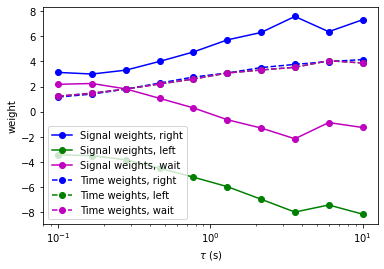

In [19]:
# Plot the weights
fig, ax = plt.subplots()
ax.plot(train_agent_data["taus"], ws[0, :n_taus], "bo-", label="Signal weights, right")
ax.plot(train_agent_data["taus"], ws[1, :n_taus], "go-", label="Signal weights, left")
ax.plot(train_agent_data["taus"], ws[2, :n_taus], "mo-", label="Signal weights, wait")
ax.plot(
    train_agent_data["taus"],
    ws[0, n_taus : 2 * n_taus],
    "bo--",
    label="Time weights, right",
)
ax.plot(
    train_agent_data["taus"],
    ws[1, n_taus : 2 * n_taus],
    "go--",
    label="Time weights, left",
)
ax.plot(
    train_agent_data["taus"],
    ws[1, n_taus : 2 * n_taus],
    "mo--",
    label="Time weights, wait",
)
ax.set_xscale("log")
ax.legend()

ax.set_xlabel(r"$\tau$ (s)")
ax.set_ylabel("weight")

print(f"Biases: right = {ws[0, 2 * n_taus]:1.3e}, left = {ws[1, 2 * n_taus]:1.3e}, wait = {ws[2, 2 * n_taus]:1.3e}")

In [85]:
# Find the weights, for example, after (roughly) 65000 training steps...
idx = find_closest(np.array(list(weights_history.keys())), [65000])[0]
print(f"Result for training step {idx}")
ws_65000 = weights_history[idx[0]]

p_mu = td_jit.get_p_mu(train_agent_data["p_mu_params"])
mus = p_mu(10 ** 5)

if "p_r_params" in train_agent_data:
    rewards = td_jit.get_p_r(train_agent_data["p_r_params"])(mus)
else:
    rewards = td_jit.get_p_r(["one"])(mus)

    
# episodes is a pandas DataFrame with:
# episode: unique identifier of the episode
# mu: value of mu during the episode
# a: action taken by the agent (0="right", 1="left", 2="wait"; in this latter case, reward is always 0 and rt = t_max)
# r: reward deliverd (0 or 1)
# rt: response time (in number of dts; so you have to multiply it for dt = 10 ms)
# abs_mu: absolute value of mu
episodes, _ = td_jit.generate_episodes(
    ws_65000,
    taus=train_agent_data["taus"],
    dt=train_agent_data["dt"],
    t_max=train_agent_data["p_t_max_params"][1],
    sig=train_agent_data["sig"],
    sig_i=train_agent_data["sig_i"],
    gamma=train_agent_data["gamma"],
    mus=mus,
    rewards=rewards,
    use_t_integrators=train_agent_data["use_t_integrators"],
    p3_tot_abs=train_agent_data["p3_tot_abs"],
    collapse_on_abs_mu=False,
    return_signals=False,
    b_exp_i_taus=train_agent_data["b_exp_i_taus"],
)

print(f"Performance at 65000 training steps: {episodes['r'].mean() * 100:1.1f}%")

Result for training step [66699]
Performance at 65000 training steps: 81.1%


In [86]:
# And then perform a simulation (with "standard" coherences; the frist coherence is 10**-3
# pratically 0, but so it is defined a "right decision" - with exactly 0 it would be ambiguous)
mu_factor = train_agent_data["sig"] * np.sqrt(train_agent_data["dt"] / td_jit.shadlen_dt)
mus = (
    mu_factor
    * np.random.choice(
        mu_from_coherence([10 ** -3, 3.2, 6.4, 12.8, 25.6, 51.2]), 6 * 10 ** 4
    )
)
if "p_r_params" in train_agent_data:
    rewards = td_jit.get_p_r(train_agent_data["p_r_params"])(mus)
else:
    rewards = td_jit.get_p_r(["one"])(mus)

episodes, signals = td_jit.generate_episodes(
    ws_65000,
    taus=train_agent_data["taus"],
    dt=train_agent_data["dt"],
    t_max=train_agent_data["p_t_max_params"][1],
    sig=train_agent_data["sig"],
    sig_i=train_agent_data["sig_i"],
    gamma=train_agent_data["gamma"],
    mus=mus,
    rewards=rewards,
    use_t_integrators=train_agent_data["use_t_integrators"],
    p3_tot_abs=train_agent_data["p3_tot_abs"],
    collapse_on_abs_mu=False,
    return_signals=True,
    b_exp_i_taus=train_agent_data["b_exp_i_taus"],
)

# episodes is a pandas DataFrame with:
# episode: unique identifier of the episode
# mu: value of mu during the episode
# a: action taken by the agent (0="right", 1="left", 2="wait"; in this latter case, reward is always 0 and rt = t_max)
# r: reward deliverd (0 or 1)
# rt: response time (in number of dts; so you have to multiply it for dt = 10 ms)
# abs_mu: absolute value of mu
episodes.head()

,episode,mu,a,r,rt,abs_mu
0,0,0.266470,0,1.0,121,0.266470
1,1,0.063228,1,0.0,5,0.063228
2,2,0.000019,1,0.0,20,0.000019
3,3,1.424808,0,1.0,13,1.424808
4,4,0.266470,0,1.0,53,0.266470


In [87]:
# Average performance (mean reward obtained), and statistics for response times (for correct and wrong episodes)
def f(g):
    d = {}

    d["correct %"] = g["r"].mean()
    idxs = g["r"] > 0.0
    rts = g["rt"].loc[idxs].values
    if rts.size > 0:   
        d["RT (correct)"] = rts.mean()
        d["CV_RT (correct)"] = rts.std() / rts.mean()
        d["RT 5% (correct)"] = np.percentile(rts, 5)
        d["RT 95% (correct)"] = np.percentile(rts, 95)
        d["N"] = rts.size
    else:
        d["RT (correct)"] = None
        d["CV_RT (correct)"] = None
        d["RT 5% (correct)"] = None
        d["RT 95% (correct)"] = None
        d["N"] = 0
        
    rts = g["rt"].loc[~idxs].values
    if rts.size > 0:   
        d["RT (wrong)"] = rts.mean()
        d["CV_RT (wrong)"] = rts.std() / rts.mean()
        d["RT 5% (wrong)"] = np.percentile(rts, 5)
        d["RT 95% (wrong)"] = np.percentile(rts, 95)
        d["N"] = rts.size
    else:
        d["RT (wrong)"] = None
        d["CV_RT (wrong)"] = None
        d["RT 5% (wrong)"] = None
        d["RT 95% (wrong)"] = None
        d["N"] = 0

    return pd.Series(d, dtype=object)

df = episodes.groupby("mu").apply(f).reset_index()
df["coherence"] = df["mu"].transform(lambda mu: coherence_from_mu(mu / mu_factor))
df = move_col_after(df, 'coherence', 'mu')
df

,mu,coherence,correct %,RT (correct),CV_RT (correct),RT 5% (correct),RT 95% (correct),N,RT (wrong),CV_RT (wrong),RT 5% (wrong),RT 95% (wrong)
0,0.000019,0.001,0.452471,108.634233,0.402786,35.00,180.0,5472,109.633406,0.458422,29.0,200.0
1,0.063228,3.200,0.606491,106.891834,0.405859,35.00,179.0,3965,111.901387,0.462246,26.0,200.0
2,0.128599,6.400,0.748639,100.854933,0.420575,33.00,174.0,2539,110.603781,0.488167,21.0,200.0
3,0.266470,12.800,0.940187,83.460716,0.456381,27.15,153.0,583,101.981132,0.558907,12.0,200.0
4,0.576965,25.600,0.998512,48.846444,0.465016,17.00,91.0,15,29.800000,1.149213,3.4,92.4
5,1.424808,51.200,0.999700,18.639156,0.397740,8.00,32.0,3,3.333333,0.509902,1.3,4.9


Shadlen measure = 14.89 (on 60 time steps)


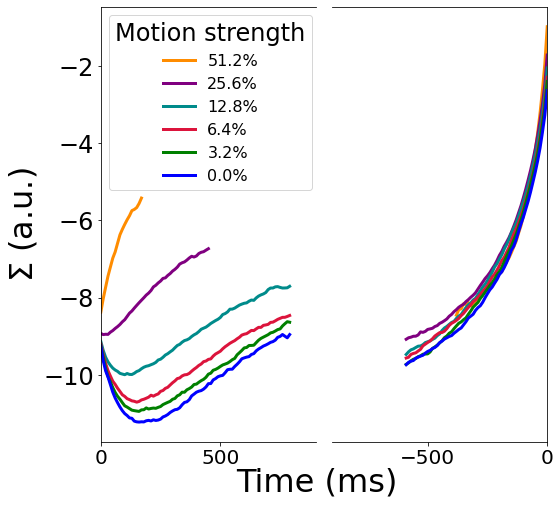

In [95]:
# Computing "Shadlen's related" measures
delta_sigma_diff_mean, delta_sigma_diff_max, delta_t = compute_shadlen_dist(
    episodes, signals, ws_65000, train_agent_data, max_delta_t=60, end_to_n_samples=100
)
print(f"Shadlen measure = {1 / delta_sigma_diff_mean:1.2f} (on {delta_t} time steps)")

align2start, align2decision = compute_shadlen(
    episodes,
    signals,
    ws_65000,
    dt=train_agent_data["dt"],
    n_t_max=None,
    p3_tot_abs=train_agent_data["p3_tot_abs"],
    start_to_percentile=50.0,
    end_to_n_samples=100,
)

coherence_f = lambda mu: coherence_from_mu(mu / mu_factor)

fig, _ = plot_shadlen(
    align2start,
    align2decision,
    ws_65000,
    dt=train_agent_data["dt"],
    coherence_f=coherence_f,
    plot_a2=False,
    p3_tot_abs=train_agent_data["p3_tot_abs"],
    plot_errors=False,
    t_max_start=0.8,
    t_max_decision=0.6,
)

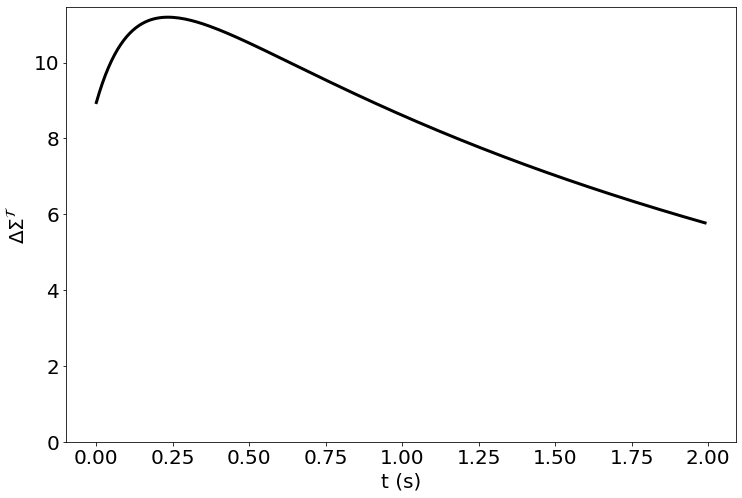

In [100]:
# Collapsing boundaries
taus = train_agent_data["taus"]
n_t_max = int(train_agent_data["p_t_max_params"][1] / train_agent_data["dt"])
ts = np.arange(0, n_t_max) * train_agent_data["dt"]
ints = np.zeros((n_t_max, n_taus))
del n_t_max
for tau_no in range(n_taus):
    ints[:, tau_no] = 1.0 - np.exp(-ts / taus[tau_no])
del tau_no

delta_sigma_t = -(
    (ws_65000[0, n_taus : 2 * n_taus] - ws_65000[2, n_taus : 2 * n_taus]) @ ints.T
    + ws_65000[0, -1]
    - ws_65000[2, -1]
)
del ints

fig, ax = plt.subplots(figsize=[12, 8])
ax.plot(ts, delta_sigma_t, "k-", linewidth=3)

ax.set_xlabel("t (s)", fontsize=20)
ax.set_ylabel(r"$\Delta \Sigma^{\mathcal{T}}}$", fontsize=20)
ax.tick_params(axis="both", which="both", labelsize=20)
ax.set_ylim([0.0, None]);